Based on the source: 
https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from torchsummary import summary
from datasets import Dataset, Features, Array2D, Value, load_dataset, load_from_disk
from random import randrange


/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/mazerl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded_data = load_from_disk(
        "/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/code-repo/Auto-encoder/autoencoder_15x15_train.hf"
    ).with_format("torch")

print(loaded_data.shape)
print(loaded_data[0]['maze'].float())
print(loaded_data[0]['groundtruth'].float())
# print(loaded_data)

(30000, 2)
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
        [0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [4]:
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        #----------------------------------------
        # Define the Neural Network Architecture
        #----------------------------------------
        
        super(ConvAutoencoder, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.AvgPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=1, output_padding=0)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, output_padding=0)
        # self.t_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2, output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, output_padding=0)

    #----------------------------------------
    # Define the Neural Network
    #----------------------------------------
    def forward(self, x):
        x = F.gelu(self.conv1(x))
        # x = self.pool(x)
        x = F.gelu(self.conv2(x))
        # x = self.pool(x)
        x = F.gelu(self.conv3(x))
        # x = self.pool(x)
        x = F.gelu(self.t_conv1(x))        
        x = F.gelu(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))
        return x

#Instantiate the model
model = ConvAutoencoder()
n = 13
summary(model, (1,n,n))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              40
            Conv2d-2           [-1, 64, 10, 10]           4,672
            Conv2d-3            [-1, 128, 8, 8]          73,856
   ConvTranspose2d-4             [-1, 64, 9, 9]          32,832
   ConvTranspose2d-5            [-1, 8, 11, 11]           4,616
   ConvTranspose2d-6            [-1, 1, 13, 13]              73
Total params: 116,089
Trainable params: 116,089
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.44
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


In [5]:
n=13
m=10000
#-----------------------------------------------------------------
# Create 10000 x 1 x 8 x 8 training input and target pairs
#-----------------------------------------------------------------
mazes = torch.zeros(m,1,n,n)
sols = torch.zeros(m,1,n,n)
for k in range(m):
    solution = torch.ones(n,n)
    problem = torch.ones(n,n)
    i,j=n-1,0

    solution = loaded_data[k]['groundtruth'].float()
    i,j=n-1,0

    problem = loaded_data[k]['maze'].float()

    mazes[k,0]=problem
    sols[k,0]=solution

#load data
dataset = torch.utils.data.TensorDataset(mazes, sols)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=0)

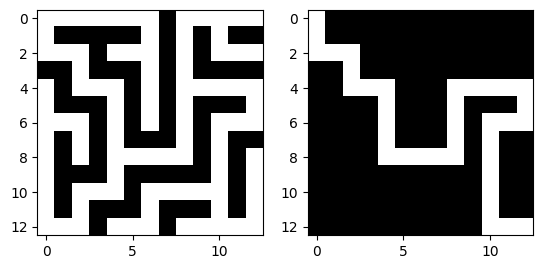

In [6]:
testMaze=torch.ones(1,n,n)
testSol=torch.ones(n,n) 

testSol=loaded_data[0]['groundtruth'].float()
testMaze[0] = loaded_data[0]['maze'].float()

fig, axes = plt.subplots(1,2)
axes[0].imshow(testMaze[0,:,:],cmap='binary')
axes[1].imshow(testSol,cmap='binary')

cpu
Epoch: 1 	Training Loss: 13.257878


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


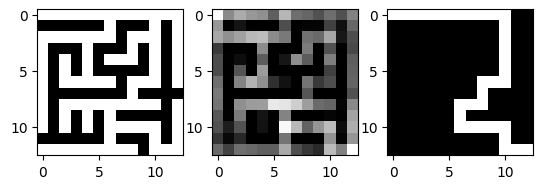

Epoch: 2 	Training Loss: 10.993888


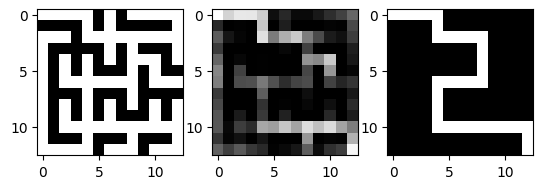

Epoch: 3 	Training Loss: 9.995364


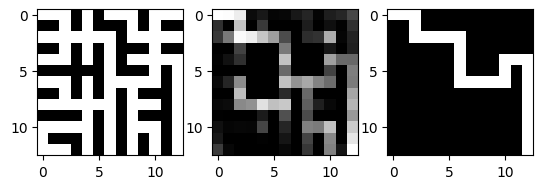

Epoch: 4 	Training Loss: 9.325246


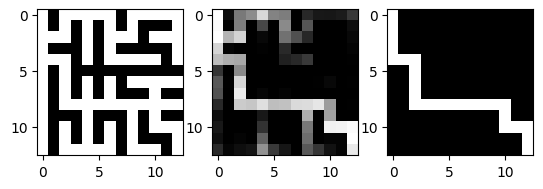

Epoch: 5 	Training Loss: 8.838173


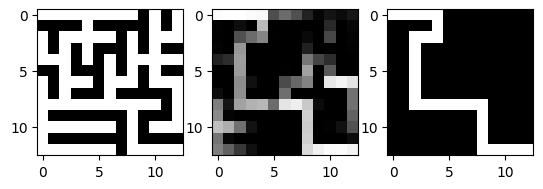

Epoch: 6 	Training Loss: 8.470547


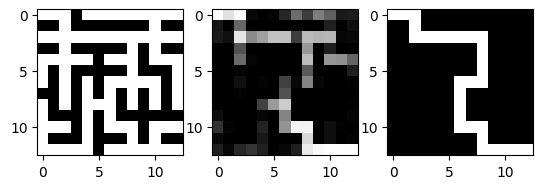

Epoch: 7 	Training Loss: 8.183603


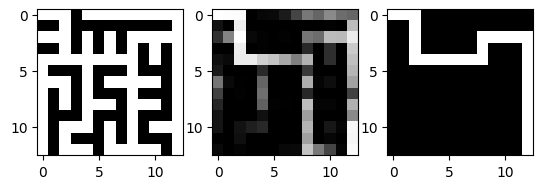

Epoch: 8 	Training Loss: 7.948522


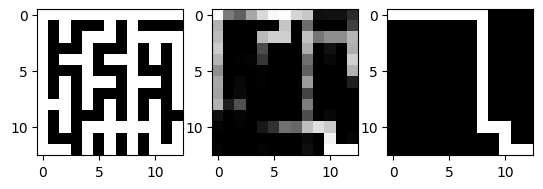

Epoch: 9 	Training Loss: 7.748391


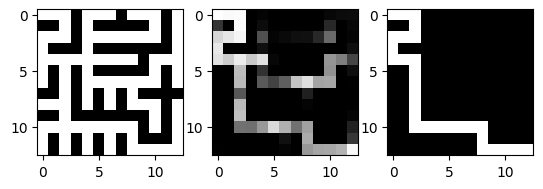

Epoch: 10 	Training Loss: 7.571763


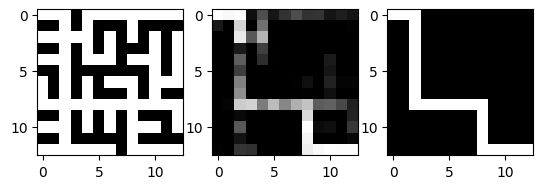

Epoch: 11 	Training Loss: 7.414008


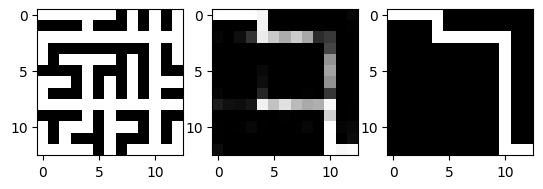

Epoch: 12 	Training Loss: 7.273752


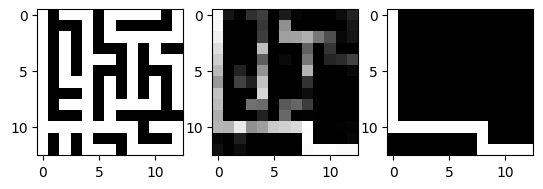

Epoch: 13 	Training Loss: 7.149017


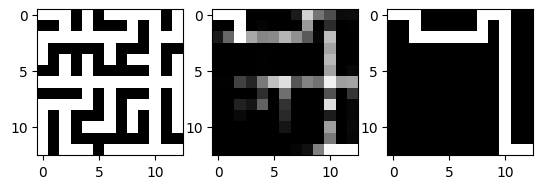

Epoch: 14 	Training Loss: 7.037014


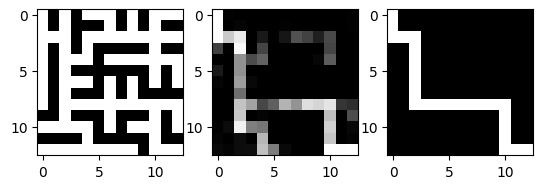

Epoch: 15 	Training Loss: 6.935130


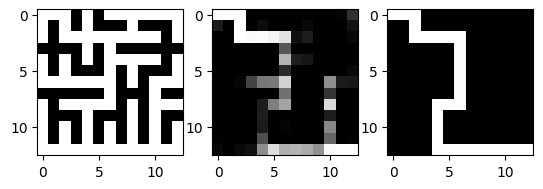

Epoch: 16 	Training Loss: 6.841212


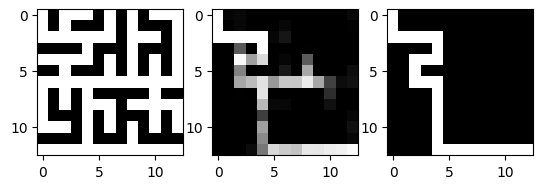

Epoch: 17 	Training Loss: 6.753638


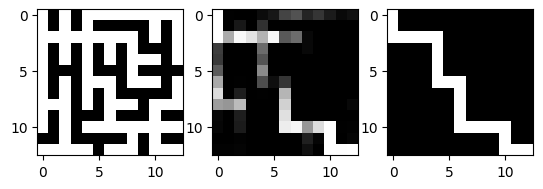

Epoch: 18 	Training Loss: 6.671118


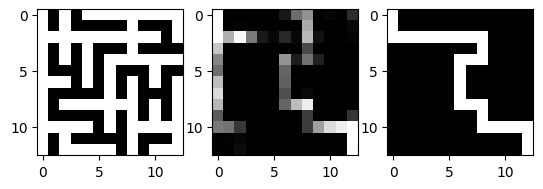

Epoch: 19 	Training Loss: 6.592380


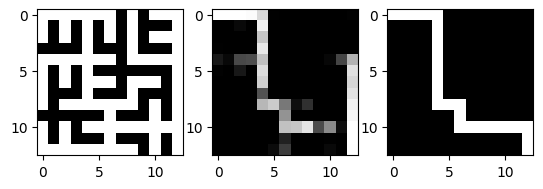

Epoch: 20 	Training Loss: 6.516421


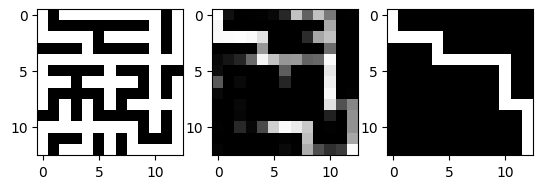

Epoch: 21 	Training Loss: 6.442941


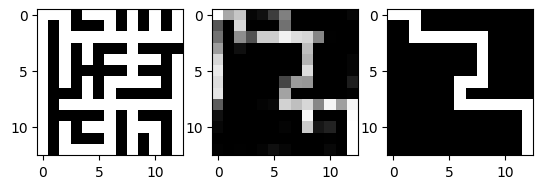

Epoch: 22 	Training Loss: 6.372010


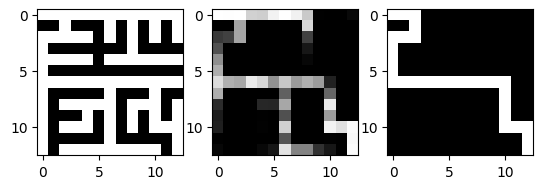

Epoch: 23 	Training Loss: 6.303517


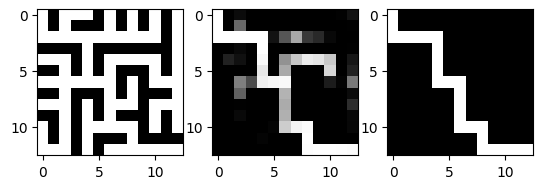

Epoch: 24 	Training Loss: 6.237379


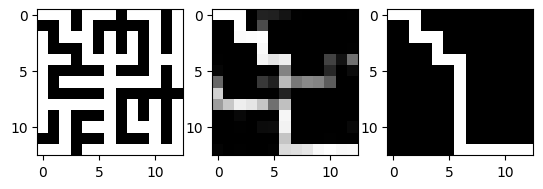

Epoch: 25 	Training Loss: 6.173260


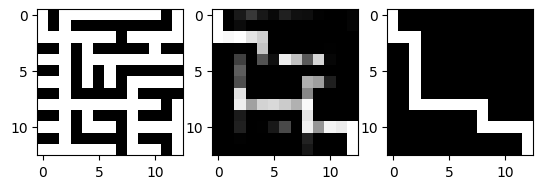

Epoch: 26 	Training Loss: 6.111006


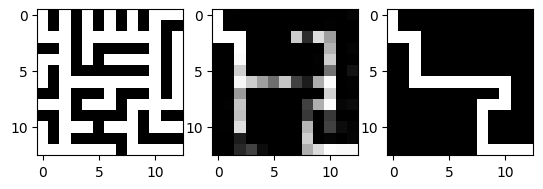

Epoch: 27 	Training Loss: 6.050720


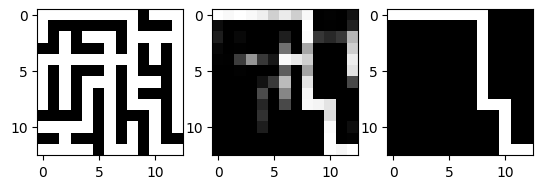

Epoch: 28 	Training Loss: 5.992290


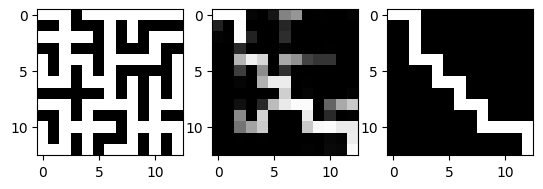

Epoch: 29 	Training Loss: 5.935269


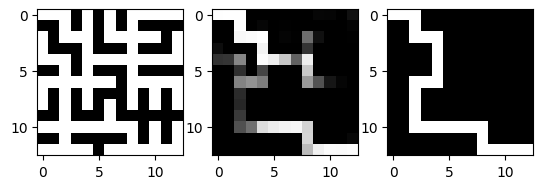

Epoch: 30 	Training Loss: 5.879421


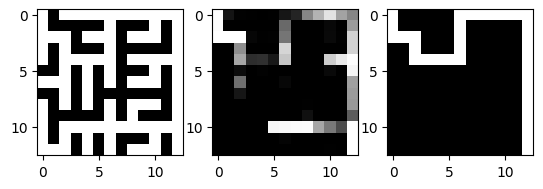

Epoch: 31 	Training Loss: 5.825059


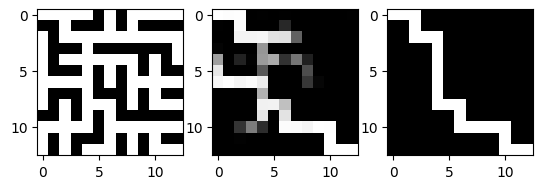

Epoch: 32 	Training Loss: 5.772362


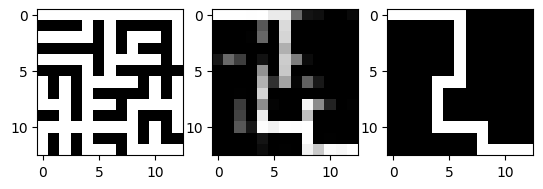

Epoch: 33 	Training Loss: 5.721527


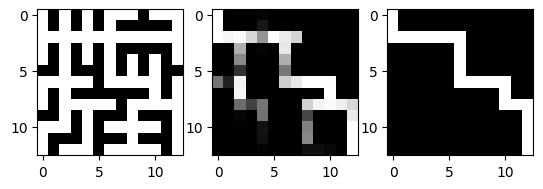

Epoch: 34 	Training Loss: 5.672298


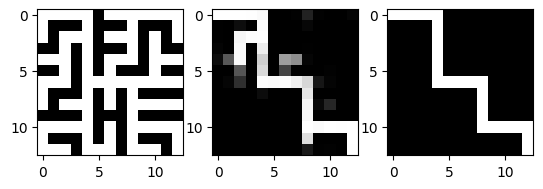

Epoch: 35 	Training Loss: 5.625186


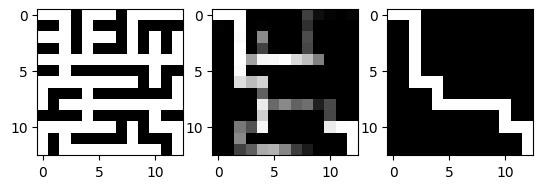

Epoch: 36 	Training Loss: 5.581600


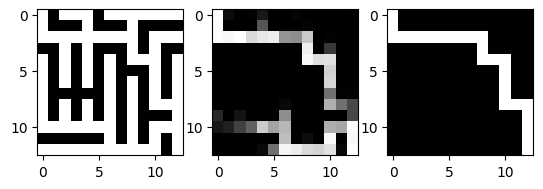

Epoch: 37 	Training Loss: 5.540571


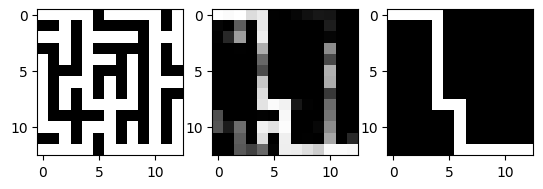

Epoch: 38 	Training Loss: 5.500447


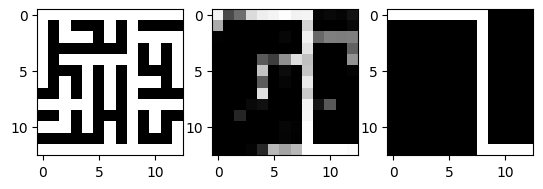

Epoch: 39 	Training Loss: 5.462874


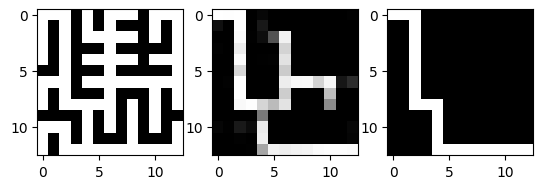

Epoch: 40 	Training Loss: 5.428293


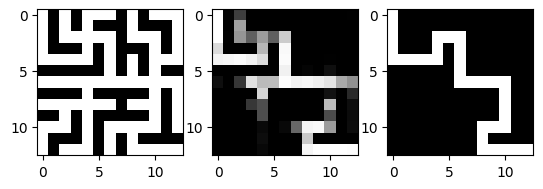

Epoch: 41 	Training Loss: 5.394317


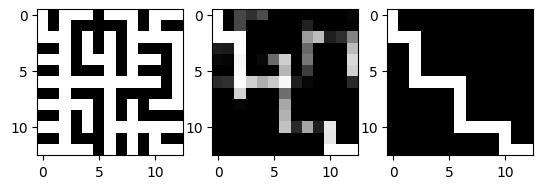

Epoch: 42 	Training Loss: 5.358225


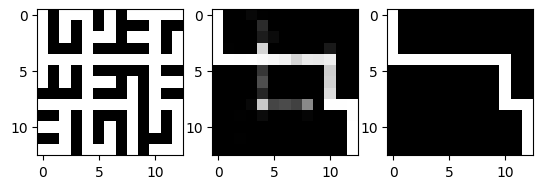

Epoch: 43 	Training Loss: 5.319770


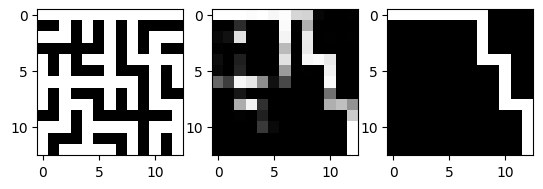

Epoch: 44 	Training Loss: 5.283908


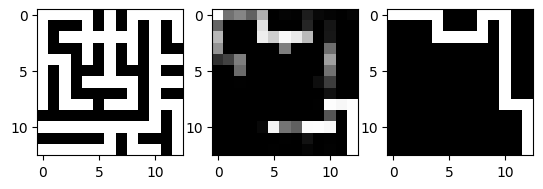

Epoch: 45 	Training Loss: 5.249920


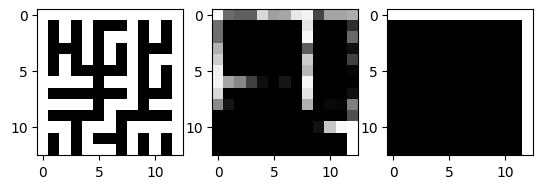

Epoch: 46 	Training Loss: 5.212987


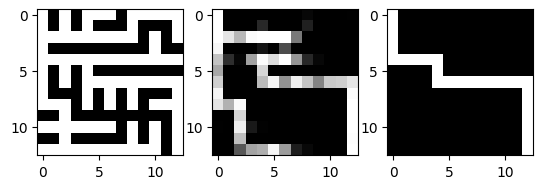

Epoch: 47 	Training Loss: 5.172405


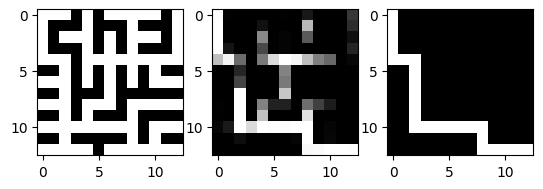

Epoch: 48 	Training Loss: 5.128632


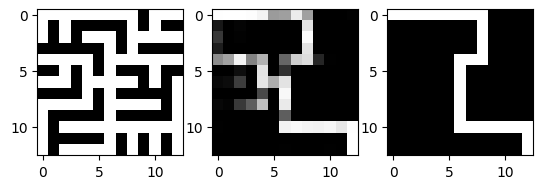

Epoch: 49 	Training Loss: 5.084989


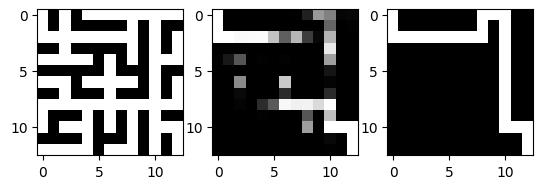

Epoch: 50 	Training Loss: 5.042848


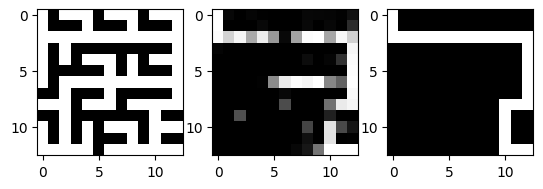

Epoch: 51 	Training Loss: 5.004552


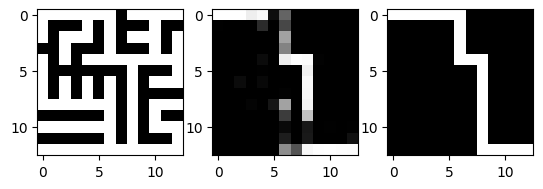

Epoch: 52 	Training Loss: 4.972453


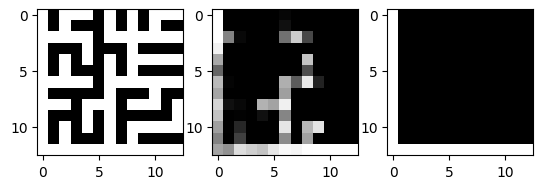

Epoch: 53 	Training Loss: 4.946074


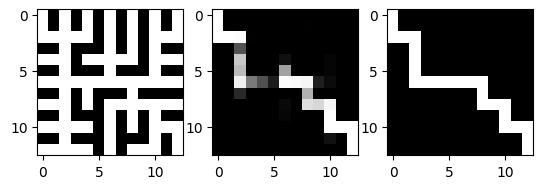

Epoch: 54 	Training Loss: 4.921806


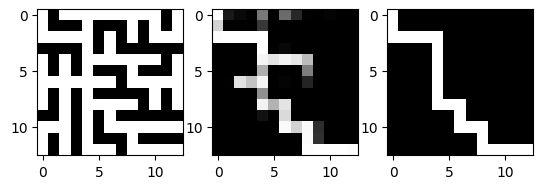

Epoch: 55 	Training Loss: 4.898730


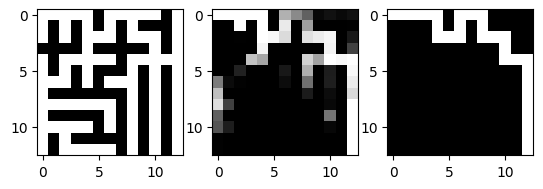

Epoch: 56 	Training Loss: 4.879785


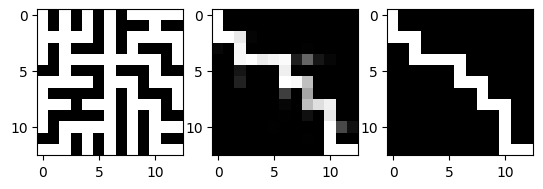

Epoch: 57 	Training Loss: 4.868671


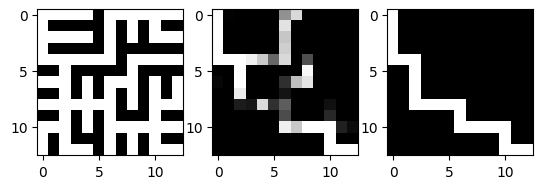

Epoch: 58 	Training Loss: 4.871999


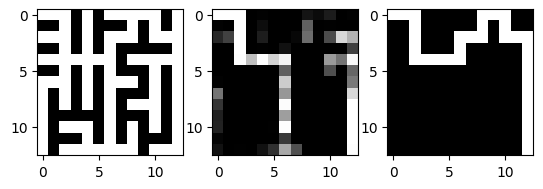

Epoch: 59 	Training Loss: 4.911507


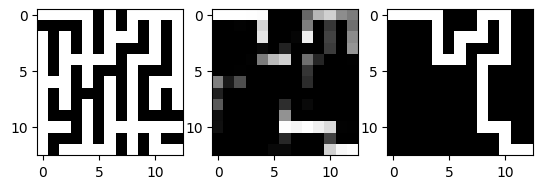

Epoch: 60 	Training Loss: 5.010937


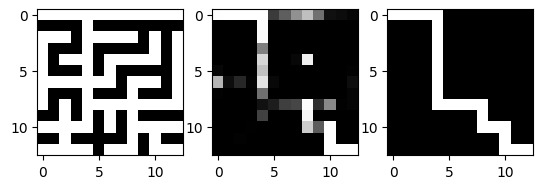

Epoch: 61 	Training Loss: 5.003633


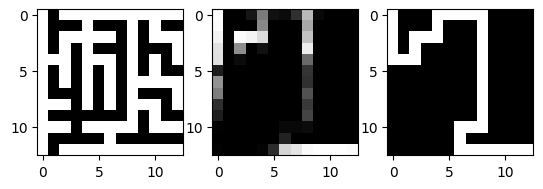

Epoch: 62 	Training Loss: 4.883238


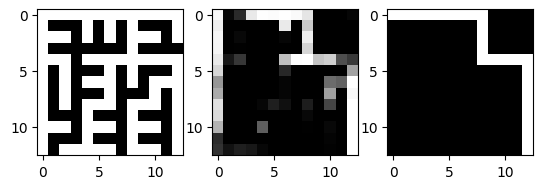

Epoch: 63 	Training Loss: 4.766540


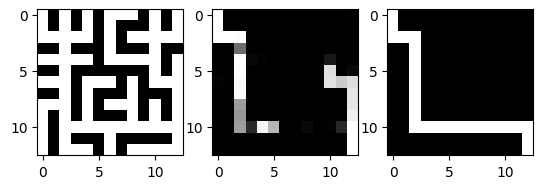

Epoch: 64 	Training Loss: 4.670270


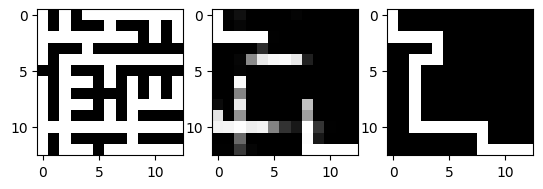

Epoch: 65 	Training Loss: 4.593217


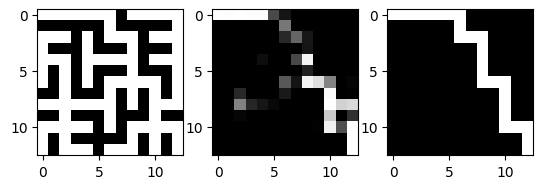

Epoch: 66 	Training Loss: 4.531596


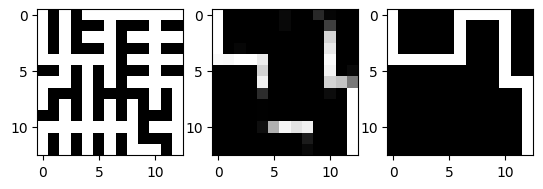

Epoch: 67 	Training Loss: 4.480868


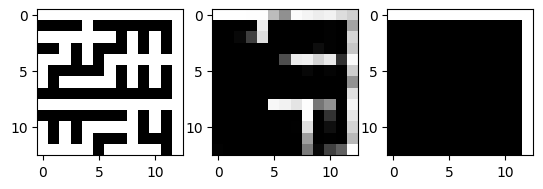

Epoch: 68 	Training Loss: 4.438304


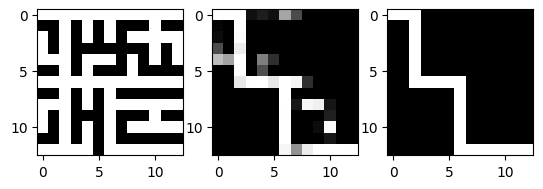

Epoch: 69 	Training Loss: 4.400953


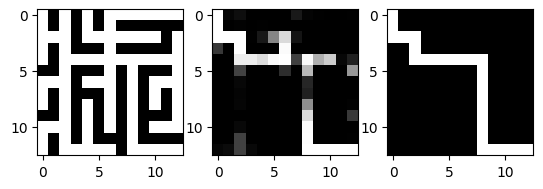

Epoch: 70 	Training Loss: 4.368064


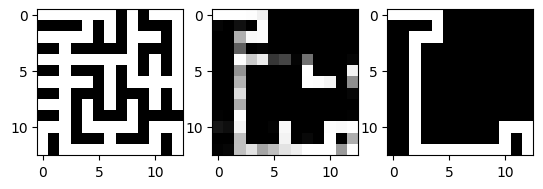

Epoch: 71 	Training Loss: 4.340796


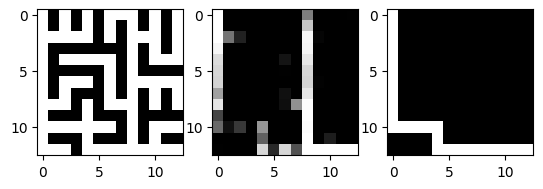

Epoch: 72 	Training Loss: 4.317784


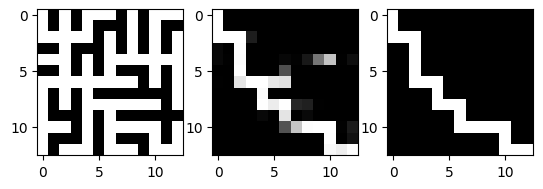

Epoch: 73 	Training Loss: 4.296266


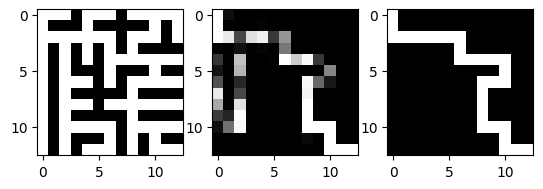

Epoch: 74 	Training Loss: 4.276525


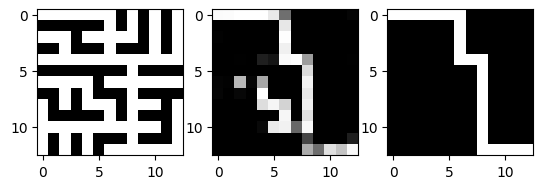

Epoch: 75 	Training Loss: 4.259699


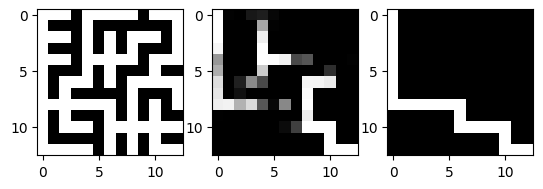

Epoch: 76 	Training Loss: 4.247694


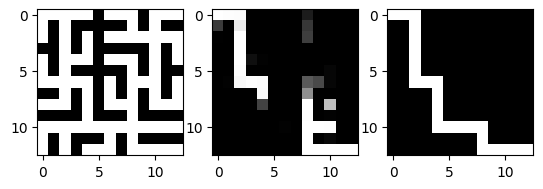

Epoch: 77 	Training Loss: 4.240295


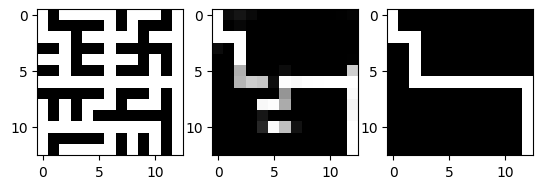

Epoch: 78 	Training Loss: 4.236308


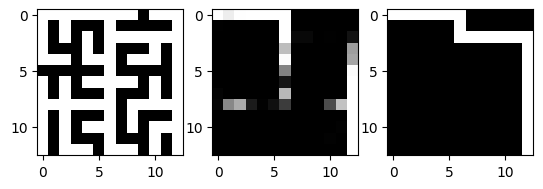

Epoch: 79 	Training Loss: 4.234068


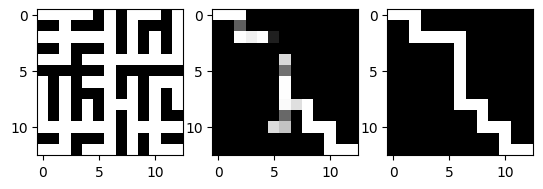

Epoch: 80 	Training Loss: 4.232919


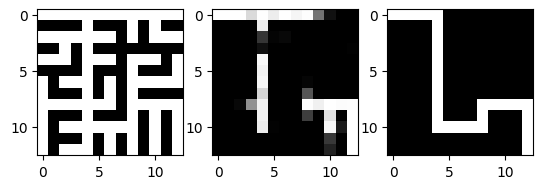

Epoch: 81 	Training Loss: 4.233738


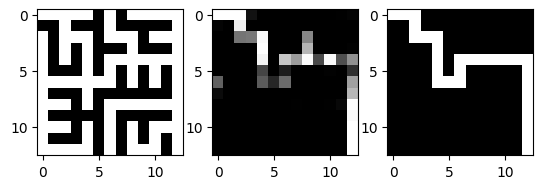

Epoch: 82 	Training Loss: 4.241414


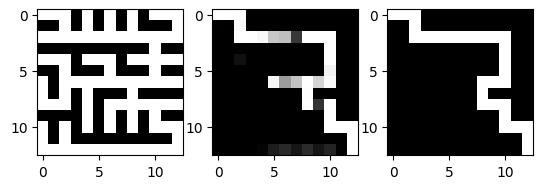

Epoch: 83 	Training Loss: 4.251860


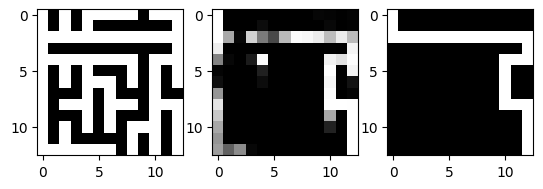

Epoch: 84 	Training Loss: 4.262613


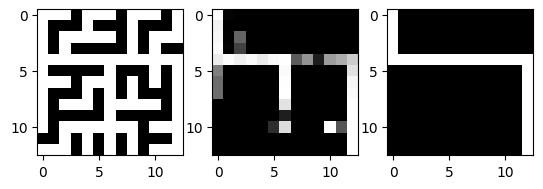

Epoch: 85 	Training Loss: 4.246926


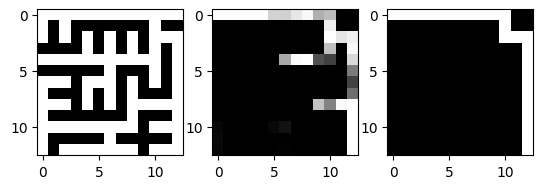

Epoch: 86 	Training Loss: 4.201186


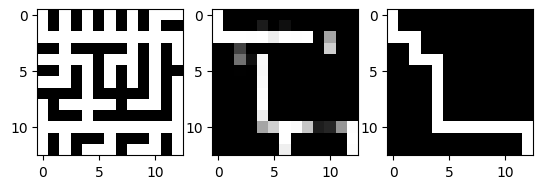

Epoch: 87 	Training Loss: 4.151776


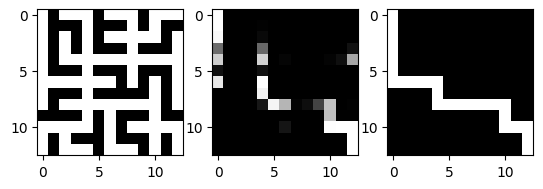

Epoch: 88 	Training Loss: 4.116666


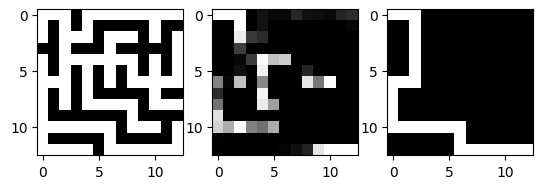

Epoch: 89 	Training Loss: 4.093761


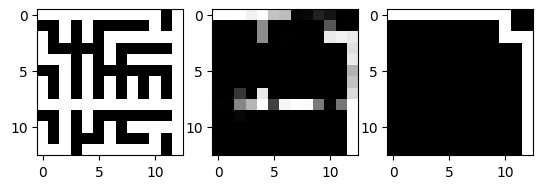

Epoch: 90 	Training Loss: 4.080127


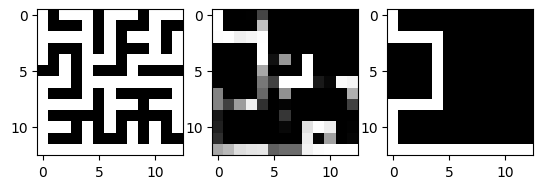

Epoch: 91 	Training Loss: 4.074980


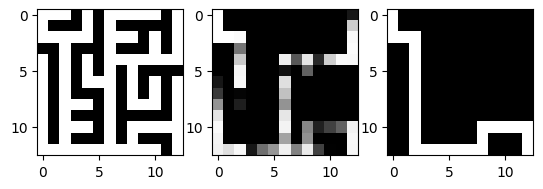

Epoch: 92 	Training Loss: 4.081244


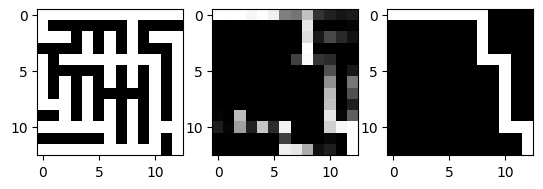

Epoch: 93 	Training Loss: 4.098732


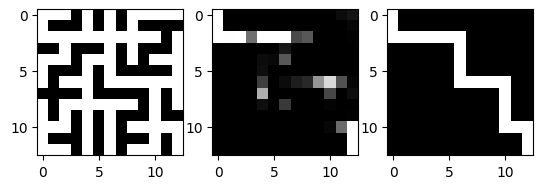

Epoch: 94 	Training Loss: 4.136800


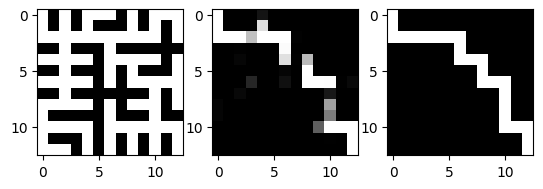

Epoch: 95 	Training Loss: 4.202817


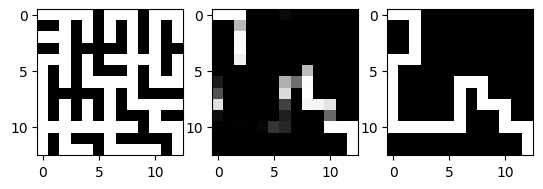

Epoch: 96 	Training Loss: 4.272506


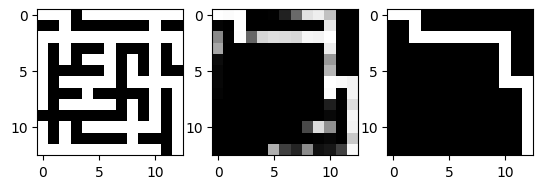

Epoch: 97 	Training Loss: 4.252633


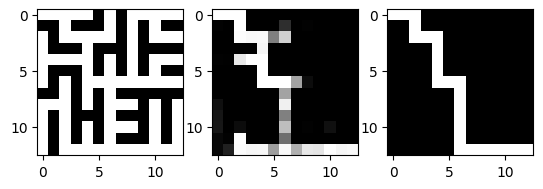

Epoch: 98 	Training Loss: 4.139266


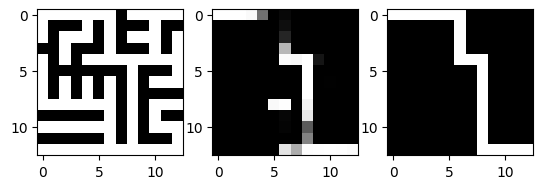

Epoch: 99 	Training Loss: 4.023912


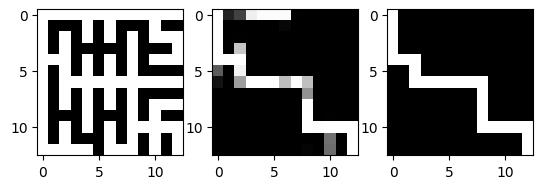

Epoch: 100 	Training Loss: 3.937039


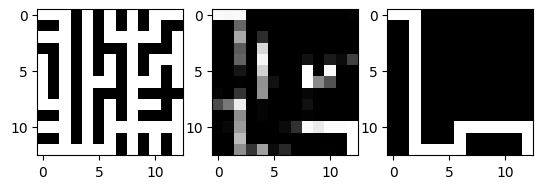

In [7]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#--------------
# Testing
#--------------

def testModel():
    testMaze=torch.ones(1,n,n)
    testSol=torch.ones(n,n) 

    random_datapoint = random.randint(20000, 29999)
    testSol=loaded_data[random_datapoint]['groundtruth'].float()
    testMaze[0] = loaded_data[random_datapoint]['maze'].float()
    testSolved = model(testMaze).detach().numpy()

    fig, axes = plt.subplots(1,3)
    axes[0].imshow(testMaze[0,:,:],cmap='binary')
    axes[1].imshow(testSolved[0,:,:],cmap='binary')
    axes[2].imshow(testSol,cmap='binary')
    
    plt.show()

#----------------------------
# Set Device
# and transfer the inputs to
# the device
#----------------------------

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

#--------------
# Training
#--------------

epochs = 100
lossList=[]
epochList=[]
for epoch in range(1, epochs+1):
    # monitor training loss
    trainLoss = 0.0
    for images, targets in dataloader:
        # images are mazes with noise
        # targets are mazes without noise
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        trainLoss += loss.item()*images.size(0)
          
    trainLoss = trainLoss/len(dataloader)
    lossList.append(trainLoss)
    epochList.append(epochs)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, trainLoss))
    testModel()

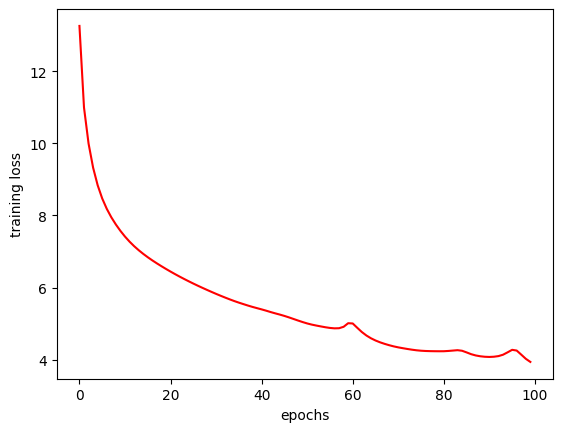

In [8]:
#----------------------------
# Loss vs Epoch graph
#----------------------------
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(lossList,color='red')
plt.show()

## Save the Model

In [9]:
PATH = './AE_15x15.pth'
torch.save(model.state_dict(), PATH)

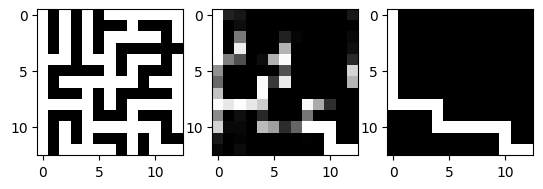

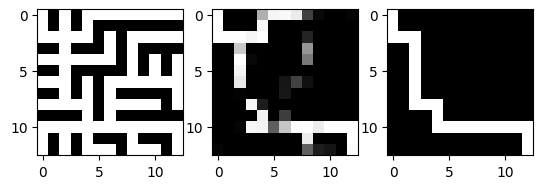

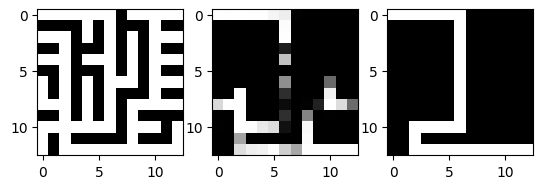

In [10]:
#----------------------------
# Testing is done for 3 images
#----------------------------

for i in range(3):
    testModel()